In [27]:
import panel as pn
import numpy as np
import os.path as osp
import pandas as pd
import os
from scipy.stats import zscore
from IPython import display

In [2]:
port_tunnel = int(os.environ['PORT2'])
print('++ INFO: Second Port available: %d' % port_tunnel)

++ INFO: Second Port available: 39447


In [3]:
from utils.basics import PRJ_DIR, PNAS2015_subject_list, sbj_cmap_list,sbj_cmap_dict
from utils.basics import le_dist_metrics, le_knns, le_ms
from utils.basics import umap_dist_metrics, umap_knns, umap_ms, umap_alphas, umap_inits
from utils.basics import tsne_dist_metrics, tsne_pps, tsne_ms, tsne_alphas, tsne_inits
from utils.basics import input_datas, norm_methods
from utils.basics import task_cmap_caps as task_cmap
from utils.basics import sbj_cmap_dict, sbj_cmap_list
from utils.plotting import plot_2d_scatter, plot_3d_scatter
from utils.io import load_LE_SI, load_UMAP_SI, load_TSNE_SI

from utils.plotting import get_SIvsKNN_plots
from utils.io import load_single_le, load_single_umap, load_single_tsne
#from utils.procrustes import procrustes_scan_embs

In [4]:
# So far we are working with these values of wls and wss across the whole manuscript
wls = 45
wss = 1.5
min_dist = 0.8

***
# Main Dashboard Panel: Configuration Options

In [5]:
sbj_select            = pn.widgets.Select(name='Subject',                 options=PNAS2015_subject_list, value=PNAS2015_subject_list[0], width=150)
input_select          = pn.widgets.Select(name='Input Data',              options=['Original','Null_ConnRand','Null_PhaseRand'],            value='Original', width=150)
scenario_select       = pn.widgets.Select(name='Normalization',           options=['asis','zscored'], value='asis', width=150)
plot2d_toolbar_select = pn.widgets.Select(name='2D Toolbar', options=['above', 'below', 'left', 'right', 'disable'], value='disable', width=150) 
data_select_box       = pn.Row(sbj_select,input_select, scenario_select, plot2d_toolbar_select, background='WhiteSmoke')
data_select_box

Row(background='WhiteSmoke')
    [0] Select(name='Subject', options=['SBJ06', 'SBJ07', ...], value='SBJ06', width=150)
    [1] Select(name='Input Data', options=['Original', 'Null_ConnRan...], value='Original', width=150)
    [2] Select(name='Normalization', options=['asis', 'zscored'], value='asis', width=150)
    [3] Select(name='2D Toolbar', options=['above', 'below', ...], value='disable', width=150)

***
# Laplacian Eigenmaps

#### 1. Load Silhouette Index for LE

In [6]:
%%time
si_LE = pd.read_pickle(osp.join(PRJ_DIR,'Dashboard','Data','si_LE.pkl'))

CPU times: user 8.32 ms, sys: 1.31 ms, total: 9.63 ms
Wall time: 8.63 ms


#### 3. LE Tab Elements

In [7]:
le_m_select     = pn.widgets.Select(name='M',               options=[2,3,5,10,15,20,25,30],         value=5, width=150)
le_knn_select   = pn.widgets.Select(name='Knn',             options=le_knns,         value=le_knns[0], width=150)
le_dist_select  = pn.widgets.Select(name='Distance Metric', options=le_dist_metrics, value=le_dist_metrics[0], width=150)
le_grcc_col_sel = pn.widgets.Select(name='[G-CC] Color By:', options=['Window Name','Subject'], value='Window Name', width=150)
le_grpt_col_sel = pn.widgets.Select(name='[G-PT] Color By:', options=['Window Name','Subject'], value='Window Name', width=150)
le_drop_xxxx    = pn.widgets.Checkbox(name='Drop Mixed Windows', width=150)
le_conf_box     = pn.WidgetBox(le_dist_select,le_knn_select,le_m_select,le_grcc_col_sel,le_grpt_col_sel,le_drop_xxxx)
le_conf_box

WidgetBox
    [0] Select(name='Distance Metric', options=['euclidean', ...], value='euclidean', width=150)
    [1] Select(name='Knn', options=[5, 10, 15, 20, ...], value=5, width=150)
    [2] Select(name='M', options=[2, 3, 5, 10, ...], value=5, width=150)
    [3] Select(name='[G-CC] Color By:', options=['Window Name', ...], value='Window Name', width=150)
    [4] Select(name='[G-PT] Color By:', options=['Window Name', ...], value='Window Name', width=150)
    [5] Checkbox(name='Drop Mixed Windows', width=150)

In [8]:
def plot_LE_scats(group_type,input_data,scenario,dist,knn,m,color_col,plot_2d_toolbar,drop_xxxx):
    plots = None
    aux_2d, aux_3d, aux_Md = None, None, None
    if group_type in ['Procrustes','ALL']:
        sitable_2d, sitable_3d, sitable_Md = pn.pane.DataFrame(pd.DataFrame(index=pd.Index(['Subject','Task'],name='Target'),columns=['SI']),width=150),pn.pane.DataFrame(pd.DataFrame(index=pd.Index(['Subject','Task'],name='Target'),columns=['SI']),width=150),pn.pane.DataFrame(pd.DataFrame(index=pd.Index(['Subject','Task'],name='Target'),columns=['SI']),width=150)
    else:
        sitable_2d, sitable_3d, sitable_Md = pn.pane.DataFrame(pd.DataFrame(index=pd.Index(['Task'],name='Target'),columns=['SI']),width=150),pn.pane.DataFrame(pd.DataFrame(index=pd.Index(['Task'],name='Target'),columns=['SI']),width=150),pn.pane.DataFrame(pd.DataFrame(index=pd.Index(['Task'],name='Target'),columns=['SI']),width=150)
    # Load all necessary embeddings
    # =============================
    if m == 2:
        aux_2d = load_single_le(group_type,input_data,scenario,dist,knn,2,drop_xxxx=drop_xxxx)
    elif m == 3:
        aux_2d = load_single_le(group_type,input_data,scenario,dist,knn,2,drop_xxxx=drop_xxxx)
        aux_3d = load_single_le(group_type,input_data,scenario,dist,knn,3,drop_xxxx=drop_xxxx)
    else:
        aux_2d = load_single_le(group_type,input_data,scenario,dist,knn,2,drop_xxxx=drop_xxxx)
        aux_3d = load_single_le(group_type,input_data,scenario,dist,knn,3,drop_xxxx=drop_xxxx)
        aux_Md = load_single_le(group_type,input_data,scenario,dist,knn,m,drop_xxxx=drop_xxxx)
    # Preprare Embeddings
    # ===================
    if not (aux_2d is None):
        aux_2d = aux_2d.apply(zscore)
        aux_2d = aux_2d.reset_index()
        aux_2d = aux_2d.sort_index(level='Window Name',ascending=False) # So Inbetween are plotted in the back (for clarity)
    if not (aux_3d is None):
        aux_3d = aux_3d.apply(zscore)
        aux_3d = aux_3d.reset_index()
        aux_3d = aux_3d.sort_index(level='Window Name',ascending=False) # So Inbetween are plotted in the back (for clarity)
    if not (aux_Md is None):
        aux_Md = aux_Md.apply(zscore)
        aux_Md = aux_Md.reset_index()
        aux_Md = aux_Md.sort_index(level='Window Name',ascending=False) # So Inbetween are plotted in the back (for clarity)
    # Prepare SI Tables
    # =================
    if (group_type,input_data,scenario,dist,knn,2) in si_LE.index:
        sitable_2d = pn.pane.DataFrame(si_LE.loc[group_type,input_data,scenario,dist,knn,2].round(2),width=150)
    if (group_type,input_data,scenario,dist,knn,3) in si_LE.index:
        sitable_3d = pn.pane.DataFrame(si_LE.loc[group_type,input_data,scenario,dist,knn,3].round(2),width=150)
    if (group_type,input_data,scenario,dist,knn,m) in si_LE.index:
        sitable_Md = pn.pane.DataFrame(si_LE.loc[group_type,input_data,scenario,dist,knn,m].round(2),width=150)
    # Prepare Color-scales
    # ====================
    if color_col == 'Subject':
        cmap_2d = sbj_cmap_dict
        cmap_3d = sbj_cmap_list
    else:
        cmap_2d = task_cmap
        if not(aux_3d is None):
            cmap_3d = [task_cmap[t] for t in aux_3d['Window Name'].unique()]
    # Plotting
    # ========
    if (not (aux_2d is None)) & (aux_3d is None):
        plots = pn.GridBox(*[plot_2d_scatter(aux_2d,x='LE001',y='LE002',c=color_col, cmap=cmap_2d, s=10, toolbar=plot_2d_toolbar),sitable_2d],ncols=1)
    if (not (aux_2d is None)) & (not (aux_3d is None)) & (aux_Md is None):
        plots = pn.GridBox(*[plot_2d_scatter(aux_2d,x='LE001',y='LE002',c=color_col, cmap=cmap_2d, s=10, toolbar=plot_2d_toolbar),
                             plot_3d_scatter(aux_3d,x='LE001',y='LE002',z='LE003',c=color_col, cmap=cmap_3d,s=3, ax_range=[-2,2]),
                             sitable_2d, sitable_3d],ncols=2)
    if (not (aux_2d is None)) & (not (aux_3d is None)) & (not (aux_Md is None)):
        plots = pn.GridBox(*[plot_2d_scatter(aux_2d,x='LE001',y='LE002',c=color_col, cmap=cmap_2d, s=10, toolbar=plot_2d_toolbar),
                             plot_3d_scatter(aux_3d,x='LE001',y='LE002',z='LE003',c=color_col, cmap=cmap_3d,s=3, ax_range=[-2,2]),
                             plot_3d_scatter(aux_Md,x='LE001',y='LE002',z='LE003',c=color_col, cmap=cmap_3d,s=3, ax_range=[-2,2]),
                             sitable_2d,sitable_3d,sitable_Md],ncols=3) 
    return plots

In [9]:
@pn.depends(input_select,scenario_select,le_dist_select,le_knn_select,le_m_select,le_grcc_col_sel,plot2d_toolbar_select,le_drop_xxxx)
def plot_LE_Group_Concat_scats(input_data,scenario,dist,knn,m,color_col,plot_2d_toolbar,drop_xxxx):
    return plot_LE_scats('ALL',input_data,scenario,dist,knn,m,color_col,plot_2d_toolbar,drop_xxxx)
@pn.depends(input_select,scenario_select,le_dist_select,le_knn_select,le_m_select,le_grpt_col_sel,plot2d_toolbar_select,le_drop_xxxx)
def plot_LE_Group_Procrustes_scats(input_data,scenario,dist,knn,m,color_col,plot_2d_toolbar,drop_xxxx):
    return plot_LE_scats('Procrustes',input_data,scenario,dist,knn,m,color_col,plot_2d_toolbar,drop_xxxx)
@pn.depends(sbj_select,input_select,scenario_select,le_dist_select,le_knn_select,le_m_select,plot2d_toolbar_select,le_drop_xxxx)
def plot_LE_Scan_scats(sbj,input_data,scenario,dist,knn,m,plot_2d_toolbar, drop_xxxx):
    return plot_LE_scats(sbj,input_data,scenario,dist,knn,m,'Window Name',plot_2d_toolbar,drop_xxxx)

In [10]:
le_figs_folder                = osp.join(PRJ_DIR,'Dashboard','Figures','LE')
le_config_card                = pn.Column(le_conf_box)
le_embs_scan_card             = pn.layout.Card(plot_LE_Scan_scats,title='Scatter Plots - One Scan', width=825)
le_embs_group_concat_card     = pn.layout.Card(plot_LE_Group_Concat_scats,title='Scatter Plots - Group Concatenation', width=825)
le_embs_group_procrustes_card = pn.layout.Card(plot_LE_Group_Procrustes_scats,title='Scatter Plots - Procrustes', width=825)
le_embs_col = pn.Column(le_embs_scan_card ,le_embs_group_concat_card,le_embs_group_procrustes_card)

In [11]:
le_tab=pn.Row(le_config_card,le_embs_col)

***
# UMAP
#### 1. Load Silhouette Index for UMAP

Hyper-parameter space: 3 Inputs * 2 Norm Approach * 8 m * 3 dist * x knns * 3 alphas = 
* "Concat + UMAP": 17280 entries
* "UMAP + Procrustes": 17280 entries
* Single-Scan Level: 345600 entries

In [12]:
si_UMAP = pd.read_pickle(osp.join(PRJ_DIR,'Dashboard','Data','si_UMAP.pkl'))

#### 3. UMAP Tab Elements

In [13]:
umap_figs_folder  = osp.join(PRJ_DIR,'Dashboard','Figures','UMAP')
umap_knn_select   = pn.widgets.Select(name='Knn',             options=umap_knns,         value=umap_knns[0], width=150)
umap_dist_select  = pn.widgets.Select(name='Distance Metric', options=umap_dist_metrics, value=umap_dist_metrics[0], width=150)
umap_m_select     = pn.widgets.Select(name='M',   options=umap_ms,           value=umap_ms[0], width=150)
umap_alpha_select = pn.widgets.Select(name='Learning Rate',   options=umap_alphas,       value=umap_alphas[0], width=150)
umap_init_select  = pn.widgets.Select(name='Init Method',     options=['spectral'],        value='spectral', width=150)
umap_mdist_select = pn.widgets.Select(name='Minimum Distance', options=[0.8],            value=0.8, width=150)
umap_grcc_col_sel = pn.widgets.Select(name='[G-CC] Color By:', options=['Window Name','Subject','Alertness','Focus','Consistency','Dificulty'], value='Window Name', width=150)
umap_grpt_col_sel = pn.widgets.Select(name='[G-PT] Color By:', options=['Window Name','Subject','Alertness','Focus','Consistency','Dificulty'], value='Window Name', width=150)
umap_drop_xxxx    = pn.widgets.Checkbox(name='Drop Mixed Windows', width=150)

umap_conf_box     = pn.WidgetBox(umap_dist_select,umap_knn_select,umap_init_select,umap_m_select,umap_alpha_select,umap_mdist_select,umap_grcc_col_sel,umap_grpt_col_sel,umap_drop_xxxx)

umap_LEFT_col     = pn.Column(umap_conf_box)
umap_LEFT_col

Column
    [0] WidgetBox
        [0] Select(name='Distance Metric', options=['euclidean', ...], value='euclidean', width=150)
        [1] Select(name='Knn', options=[5, 10, 15, 20, ...], value=5, width=150)
        [2] Select(name='Init Method', options=['spectral'], value='spectral', width=150)
        [3] Select(name='M', options=[2, 3, 5, 10, ...], value=2, width=150)
        [4] Select(name='Learning Rate', options=[0.01, 0.1, 1.0], value=0.01, width=150)
        [5] Select(name='Minimum Distance', options=[0.8], value=0.8, width=150)
        [6] Select(name='[G-CC] Color By:', options=['Window Name', ...], value='Window Name', width=150)
        [7] Select(name='[G-PT] Color By:', options=['Window Name', ...], value='Window Name', width=150)
        [8] Checkbox(name='Drop Mixed Windows', width=150)

#### 3. Plotting Functions            

In [14]:
def plot_UMAP_scats(group_type,input_data,scenario,dist,knn,m,alpha,init_method,min_dist,color_col,plot_2d_toolbar,drop_xxxx):
    plots = None
    aux_2d, aux_3d, aux_Md = None, None, None
    if group_type in ['Procrustes','ALL']:
        sitable_2d, sitable_3d, sitable_Md = pn.pane.DataFrame(pd.DataFrame(index=pd.Index(['Subject','Task'],name='Target'),columns=['SI']),width=150),pn.pane.DataFrame(pd.DataFrame(index=pd.Index(['Subject','Task'],name='Target'),columns=['SI']),width=150),pn.pane.DataFrame(pd.DataFrame(index=pd.Index(['Subject','Task'],name='Target'),columns=['SI']),width=150)
    else:
        sitable_2d, sitable_3d, sitable_Md = pn.pane.DataFrame(pd.DataFrame(index=pd.Index(['Task'],name='Target'),columns=['SI']),width=150),pn.pane.DataFrame(pd.DataFrame(index=pd.Index(['Task'],name='Target'),columns=['SI']),width=150),pn.pane.DataFrame(pd.DataFrame(index=pd.Index(['Task'],name='Target'),columns=['SI']),width=150)
    # Load all necessary embeddings
    # =============================
    if m == 2:
        aux_2d = load_single_umap(group_type,input_data,scenario,dist,knn,alpha,init_method,min_dist,2,drop_xxxx=drop_xxxx)
    elif m == 3:
        aux_2d = load_single_umap(group_type,input_data,scenario,dist,knn,alpha,init_method,min_dist,2,drop_xxxx=drop_xxxx)
        aux_3d = load_single_umap(group_type,input_data,scenario,dist,knn,alpha,init_method,min_dist,3,drop_xxxx=drop_xxxx)
    else:
        aux_2d = load_single_umap(group_type,input_data,scenario,dist,knn,alpha,init_method,min_dist,2,drop_xxxx=drop_xxxx)
        aux_3d = load_single_umap(group_type,input_data,scenario,dist,knn,alpha,init_method,min_dist,3,drop_xxxx=drop_xxxx)
        aux_Md = load_single_umap(group_type,input_data,scenario,dist,knn,alpha,init_method,min_dist,m,drop_xxxx=drop_xxxx)
    # Preprare Embeddings
    # ===================
    if not (aux_2d is None):
        aux_2d = aux_2d.apply(zscore)
        aux_2d = aux_2d.reset_index()
        aux_2d = aux_2d.sort_index(level='Window Name',ascending=False) # So Inbetween are plotted in the back (for clarity)
    if not (aux_3d is None):
        aux_3d = aux_3d.apply(zscore)
        aux_3d = aux_3d.reset_index()
        aux_3d = aux_3d.sort_index(level='Window Name',ascending=False) # So Inbetween are plotted in the back (for clarity)
    if not (aux_Md is None):
        aux_Md = aux_Md.apply(zscore)
        aux_Md = aux_Md.reset_index()
        aux_Md = aux_Md.sort_index(level='Window Name',ascending=False) # So Inbetween are plotted in the back (for clarity)
    # Prepare SI Tables
    # =================
    if (group_type,input_data,scenario,init_method,min_dist,dist,knn,alpha,2) in si_UMAP.index:
        sitable_2d = pn.pane.DataFrame(si_UMAP.loc[group_type,input_data,scenario,init_method,min_dist,dist,knn,alpha,2].round(2),width=150)
    if (group_type,input_data,scenario,init_method,min_dist,dist,knn,alpha,3) in si_UMAP.index:
        sitable_3d = pn.pane.DataFrame(si_UMAP.loc[group_type,input_data,scenario,init_method,min_dist,dist,knn,alpha,3].round(2),width=150)
    if (group_type,input_data,scenario,init_method,min_dist,dist,knn,alpha,m) in si_UMAP.index:
        sitable_Md = pn.pane.DataFrame(si_UMAP.loc[group_type,input_data,scenario,init_method,min_dist,dist,knn,alpha,m].round(2),width=150)
    # Prepare Color-scales
    # ====================
    if color_col == 'Subject':
        cmap_2d = sbj_cmap_dict
        cmap_3d = sbj_cmap_list
    else:
        cmap_2d = task_cmap
        if not(aux_3d is None):
            cmap_3d = [task_cmap[t] for t in aux_3d['Window Name'].unique()]
    # Plotting
    # ========
    if (not (aux_2d is None)) & (aux_3d is None):
        plots = pn.GridBox(*[plot_2d_scatter(aux_2d,x='UMAP001',y='UMAP002',c=color_col, cmap=cmap_2d, s=10, toolbar=plot_2d_toolbar),sitable_2d],ncols=1)
    if (not (aux_2d is None)) & (not (aux_3d is None)) & (aux_Md is None):
        plots = pn.GridBox(*[plot_2d_scatter(aux_2d,x='UMAP001',y='UMAP002',c=color_col, cmap=cmap_2d, s=10, toolbar=plot_2d_toolbar),
                             plot_3d_scatter(aux_3d,x='UMAP001',y='UMAP002',z='UMAP003',c=color_col, cmap=cmap_3d,s=3, ax_range=[-2,2]),
                             sitable_2d, sitable_3d],ncols=2)
    if (not (aux_2d is None)) & (not (aux_3d is None)) & (not (aux_Md is None)):
        plots = pn.GridBox(*[plot_2d_scatter(aux_2d,x='UMAP001',y='UMAP002',c=color_col, cmap=cmap_2d, s=10, toolbar=plot_2d_toolbar),
                             plot_3d_scatter(aux_3d,x='UMAP001',y='UMAP002',z='UMAP003',c=color_col, cmap=cmap_3d,s=3, ax_range=[-2,2]),
                             plot_3d_scatter(aux_Md,x='UMAP001',y='UMAP002',z='UMAP003',c=color_col, cmap=cmap_3d,s=3, ax_range=[-2,2]),
                             sitable_2d,sitable_3d,sitable_Md],ncols=3) 
    return plots

In [15]:
@pn.depends(input_select,scenario_select,umap_dist_select,umap_knn_select,umap_m_select,umap_alpha_select,umap_init_select,umap_mdist_select,umap_grcc_col_sel,plot2d_toolbar_select,umap_drop_xxxx)
def plot_UMAP_Group_Concat_scats(input_data,scenario,dist,knn,m,alpha,init_method,min_dist,color_col,plot_2d_toolbar,drop_xxxx):
    return plot_UMAP_scats('ALL',input_data,scenario,dist,knn,m,alpha,init_method,min_dist,color_col,plot_2d_toolbar,drop_xxxx)
@pn.depends(input_select,scenario_select,umap_dist_select,umap_knn_select,umap_m_select,umap_alpha_select,umap_init_select,umap_mdist_select,umap_grpt_col_sel,plot2d_toolbar_select,umap_drop_xxxx)
def plot_UMAP_Group_Procustes_scats(input_data,scenario,dist,knn,m,alpha,init_method,min_dist,color_col,plot_2d_toolbar,drop_xxxx):
    return plot_UMAP_scats('Procrustes',input_data,scenario,dist,knn,m,alpha,init_method,min_dist,color_col,plot_2d_toolbar,drop_xxxx)
@pn.depends(sbj_select,input_select,scenario_select,umap_dist_select,umap_knn_select,umap_m_select,umap_alpha_select,umap_init_select,umap_mdist_select,plot2d_toolbar_select,umap_drop_xxxx)
def plot_UMAP_Scan_scats(sbj,input_data,scenario,dist,knn,m,alpha,init_method,min_dist,plot_2d_toolbar,drop_xxxx):
    return plot_UMAP_scats(sbj,input_data,scenario,dist,knn,m,alpha,init_method,min_dist,'Window Name',plot_2d_toolbar,drop_xxxx)

#### 4. Constructing UMAP Tab with all elements

In [16]:
umap_embs_scan_card             = pn.layout.Card(plot_UMAP_Scan_scats,title='Scatter Plots - One Scan', width=825)
umap_embs_group_concat_card     = pn.layout.Card(plot_UMAP_Group_Concat_scats,title='Scatter Plots - Group Concatenation', width=825)
umap_embs_group_procrustes_card = pn.layout.Card(plot_UMAP_Group_Procustes_scats,title='Scatter Plots - Procrustes', width=825)
umap_embs_col = pn.Column(umap_embs_scan_card ,umap_embs_group_concat_card,umap_embs_group_procrustes_card)

In [17]:
umap_tab = pn.Row(umap_LEFT_col,umap_embs_col)

***
# TSNE
#### 1. Load Silhouette Index for TSNE

In [18]:
si_TSNE = pd.read_pickle(osp.join(PRJ_DIR,'Dashboard','Data','si_TSNE.pkl'))

#### 2. TSNE Tab Elements

In [19]:
tsne_figs_folder  = osp.join(PRJ_DIR,'Dashboard','Figures','TSNE')
tsne_pp_select   = pn.widgets.Select(name='Perplexity',        options=tsne_pps,          value=50, width=150)
tsne_dist_select  = pn.widgets.Select(name='Distance Metric',  options=tsne_dist_metrics, value='correlation', width=150)
tsne_m_select     = pn.widgets.Select(name='M',                options=[2,3,5,10,15,20,25,30],       value=2, width=150)
tsne_alpha_select = pn.widgets.Select(name='Learning Rate',    options=tsne_alphas,       value=tsne_alphas[0], width=150)
tsne_init_select  = pn.widgets.Select(name='Init Method',      options=tsne_inits,       value=tsne_inits[0], width=150)
tsne_grcc_col_sel = pn.widgets.Select(name='[G-CC] Color By:', options=['Window Name','Subject'], value='Window Name', width=150)
tsne_grpt_col_sel = pn.widgets.Select(name='[G-PT] Color By:', options=['Window Name','Subject'], value='Window Name', width=150)
tsne_drop_xxxx    = pn.widgets.Checkbox(name='Drop Mixed Windows', width=150)

tsne_conf_box     = pn.WidgetBox(tsne_dist_select,tsne_pp_select,tsne_init_select,tsne_m_select,tsne_alpha_select,tsne_grcc_col_sel,tsne_grpt_col_sel,tsne_drop_xxxx)

tsne_LEFT_col     = pn.Column(tsne_conf_box)

#### 3. Plotting Functions

In [20]:
def plot_TSNE_scats(group_type,input_data,scenario,dist,pp,m,alpha,init_method,color_col,plot_2d_toolbar, drop_xxxx):
    plots = None
    aux_2d, aux_3d, aux_Md = None, None, None
    if group_type in ['Procrustes','ALL']:
        sitable_2d, sitable_3d, sitable_Md = pn.pane.DataFrame(pd.DataFrame(index=pd.Index(['Subject','Task'],name='Target'),columns=['SI']),width=150),pn.pane.DataFrame(pd.DataFrame(index=pd.Index(['Subject','Task'],name='Target'),columns=['SI']),width=150),pn.pane.DataFrame(pd.DataFrame(index=pd.Index(['Subject','Task'],name='Target'),columns=['SI']),width=150)
    else:
        sitable_2d, sitable_3d, sitable_Md = pn.pane.DataFrame(pd.DataFrame(index=pd.Index(['Task'],name='Target'),columns=['SI']),width=150),pn.pane.DataFrame(pd.DataFrame(index=pd.Index(['Task'],name='Target'),columns=['SI']),width=150),pn.pane.DataFrame(pd.DataFrame(index=pd.Index(['Task'],name='Target'),columns=['SI']),width=150)
    # Load all necessary embeddings
    # =============================
    if m == 2:
        aux_2d = load_single_tsne(group_type,input_data,scenario,dist,pp,alpha,init_method,2,drop_xxxx=drop_xxxx)
    elif m == 3:
        aux_2d = load_single_tsne(group_type,input_data,scenario,dist,pp,alpha,init_method,2,drop_xxxx=drop_xxxx)
        aux_3d = load_single_tsne(group_type,input_data,scenario,dist,pp,alpha,init_method,3,drop_xxxx=drop_xxxx)
    else:
        aux_2d = load_single_tsne(group_type,input_data,scenario,dist,pp,alpha,init_method,2,drop_xxxx=drop_xxxx)
        aux_3d = load_single_tsne(group_type,input_data,scenario,dist,pp,alpha,init_method,3,drop_xxxx=drop_xxxx)
        aux_Md = load_single_tsne(group_type,input_data,scenario,dist,pp,alpha,init_method,m,drop_xxxx=drop_xxxx)
    # Preprare Embeddings for plotting purposes
    # =========================================
    if not (aux_2d is None):
        aux_2d = aux_2d.apply(zscore)
        aux_2d = aux_2d.reset_index()
        aux_2d = aux_2d.sort_index(level='Window Name',ascending=False) # So Inbetween are plotted in the back (for clarity)
    if not (aux_3d is None):
        aux_3d = aux_3d.apply(zscore)
        aux_3d = aux_3d.reset_index()
        aux_3d = aux_3d.sort_index(level='Window Name',ascending=False) # So Inbetween are plotted in the back (for clarity)
    if not (aux_Md is None):
        aux_Md = aux_Md.apply(zscore)
        aux_Md = aux_Md.reset_index()
        aux_Md = aux_Md.sort_index(level='Window Name',ascending=False) # So Inbetween are plotted in the back (for clarity)
    # Prepare SI Tables
    # =================
    if (group_type,input_data,scenario,dist,pp,2,alpha,init_method) in si_TSNE.index:
        sitable_2d = pn.pane.DataFrame(si_TSNE.loc[group_type,input_data,scenario,dist,pp,2,alpha,init_method].round(2),width=150)
    if (group_type,input_data,scenario,dist,pp,3,alpha,init_method) in si_TSNE.index:
        sitable_3d = pn.pane.DataFrame(si_TSNE.loc[group_type,input_data,scenario,dist,pp,3,alpha,init_method].round(2),width=150)
    if (group_type,input_data,scenario,dist,pp,m,alpha,init_method) in si_TSNE.index:
        sitable_Md = pn.pane.DataFrame(si_TSNE.loc[group_type,input_data,scenario,dist,pp,m,alpha,init_method].round(2),width=150)
    # Prepare Color-scales
    # ====================
    if color_col == 'Subject':
        cmap_2d = sbj_cmap_dict
        cmap_3d = sbj_cmap_list
    else:
        cmap_2d = task_cmap
        if not(aux_3d is None):
            cmap_3d = [task_cmap[t] for t in aux_3d['Window Name'].unique()]    
    # Plotting
    # ========
    if (not (aux_2d is None)) & (aux_3d is None):
        plots = pn.GridBox(*[plot_2d_scatter(aux_2d,x='TSNE001',y='TSNE002',c=color_col, cmap=cmap_2d, s=10, toolbar=plot_2d_toolbar),sitable_2d],ncols=1)
    if (not (aux_2d is None)) & (not (aux_3d is None)) & (aux_Md is None):
        plots = pn.GridBox(*[plot_2d_scatter(aux_2d,x='TSNE001',y='TSNE002',c=color_col, cmap=cmap_2d, s=10, toolbar=plot_2d_toolbar),
                             plot_3d_scatter(aux_3d,x='TSNE001',y='TSNE002',z='TSNE003',c=color_col, cmap=cmap_3d,s=3, ax_range=[-2,2]),
                             sitable_2d, sitable_3d],ncols=2)
    if (not (aux_2d is None)) & (not (aux_3d is None)) & (not (aux_Md is None)):
        plots = pn.GridBox(*[plot_2d_scatter(aux_2d,x='TSNE001',y='TSNE002',c=color_col, cmap=cmap_2d, s=10, toolbar=plot_2d_toolbar),
                             plot_3d_scatter(aux_3d,x='TSNE001',y='TSNE002',z='TSNE003',c=color_col, cmap=cmap_3d,s=3, ax_range=[-2,2]),
                             plot_3d_scatter(aux_Md,x='TSNE001',y='TSNE002',z='TSNE003',c=color_col, cmap=cmap_3d,s=3, ax_range=[-2,2]),
                             sitable_2d, sitable_3d, sitable_Md],ncols=3)
    return plots

In [21]:
@pn.depends(input_select,scenario_select,tsne_dist_select,tsne_pp_select,tsne_m_select,tsne_alpha_select,tsne_init_select,tsne_grpt_col_sel,plot2d_toolbar_select,tsne_drop_xxxx)
def plot_TSNE_Group_Procustes_scats(input_data,scenario,dist,pp,m,alpha,init_method,color_col,plot_2d_toolbar, drop_xxxx):
    return plot_TSNE_scats('Procrustes',input_data,scenario,dist,pp,m,alpha,init_method,color_col,plot_2d_toolbar, drop_xxxx)
@pn.depends(input_select,scenario_select,tsne_dist_select,tsne_pp_select,tsne_m_select,tsne_alpha_select,tsne_init_select,tsne_grcc_col_sel,plot2d_toolbar_select,tsne_drop_xxxx)
def plot_TSNE_Group_Concat_scats(input_data,scenario,dist,pp,m,alpha,init_method,color_col,plot_2d_toolbar,drop_xxxx):
    return plot_TSNE_scats('ALL',input_data,scenario,dist,pp,m,alpha,init_method,color_col,plot_2d_toolbar, drop_xxxx)
@pn.depends(sbj_select,input_select,scenario_select,tsne_dist_select,tsne_pp_select,tsne_m_select,tsne_alpha_select,tsne_init_select,plot2d_toolbar_select,tsne_drop_xxxx)
def plot_TSNE_Scan_scats(sbj,input_data,scenario,dist,pp,m,alpha,init_method,plot_2d_toolbar,drop_xxxx):
    return plot_TSNE_scats(sbj,input_data,scenario,dist,pp,m,alpha,init_method,'Window Name',plot_2d_toolbar, drop_xxxx)

#### 4. Put the T-SNE Tab elements together

In [22]:
tsne_embs_scan_card             = pn.layout.Card(plot_TSNE_Scan_scats,title='Scatter Plots - One Scan', width=825)
tsne_embs_group_concat_card     = pn.layout.Card(plot_TSNE_Group_Concat_scats,title='Scatter Plots - Group Concatenation', width=825)
tsne_embs_group_procrustes_card = pn.layout.Card(plot_TSNE_Group_Procustes_scats,title='Scatter Plots - Procrustes', width=825)
tsne_embs_col = pn.Column(tsne_embs_scan_card,tsne_embs_group_concat_card,tsne_embs_group_procrustes_card)

In [23]:
tsne_tab = pn.Row(tsne_LEFT_col,tsne_embs_col)

***

# 5. Generate and Start Dashboard

In [24]:
dashboard = pn.Column(data_select_box,pn.Tabs(('Laplacian Eigenmaps',le_tab),('TSNE',tsne_tab),('UMAP',umap_tab)))

In [25]:
dashboard_server = dashboard.show(port=port_tunnel,open=False)

Launching server at http://localhost:39447


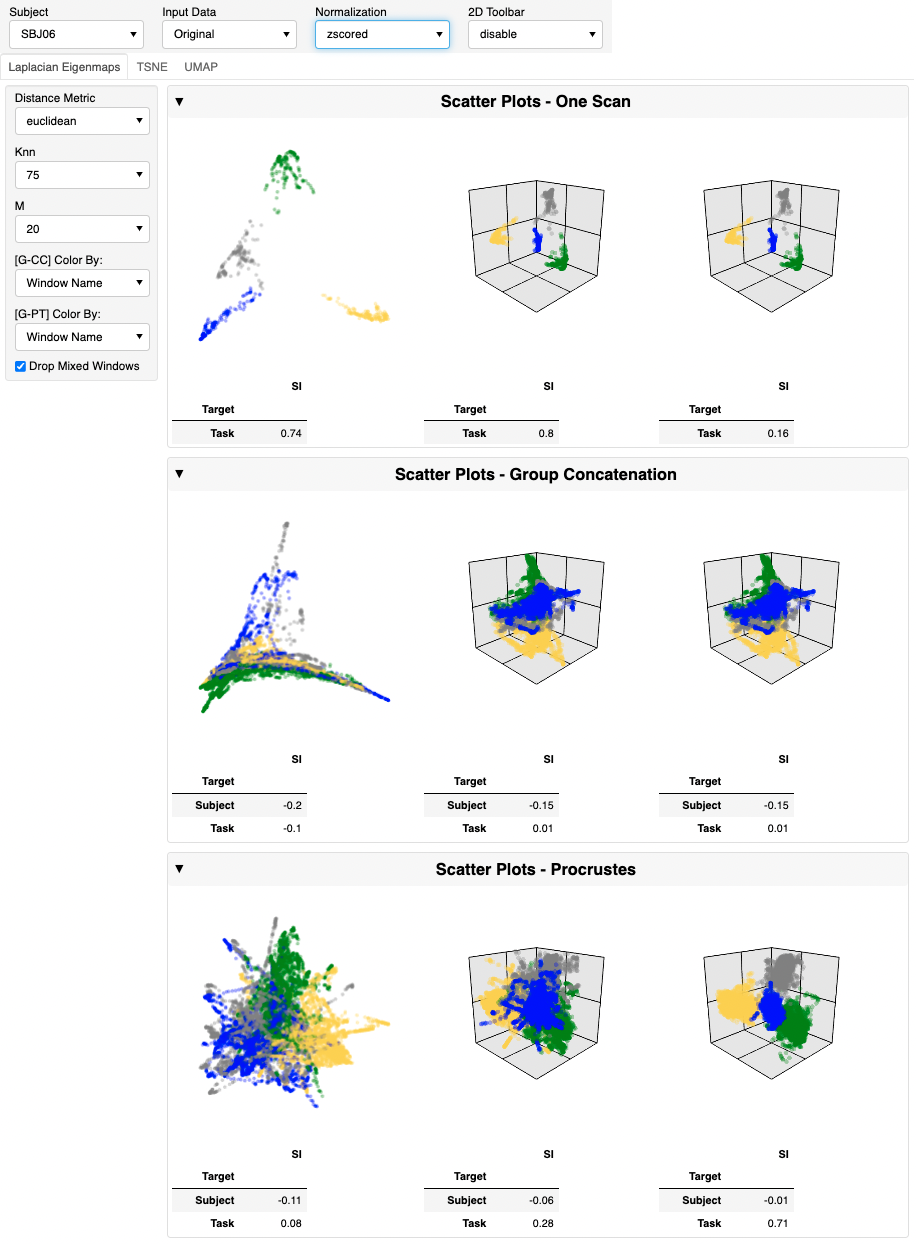

In [28]:
display.Image('../Outputs/Notebook_Figures/GUI_Embeddings.png')

In [ ]:
dashboard_server.stop()